In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', font_scale=1.5)
mpl.rcParams['figure.figsize'] = (8, 6)
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# parameters
rho = 0.05 # discount rate
alpha = 0.3 # capital elasticity
delta = 0.1 # depreciation
theta = 1.0 # crra param

## Ramsey Model

In [4]:
# algorithm
S0 = 2**16 # max number of steps in perturbation simulation
S1 = 4096 # short simulation
K = 512 # size of capital grid
ptol = 1.0e-4 # initial displacement for perturbation simulation
dt_max = 1.0 # max time step in variable delt schemes

In [5]:
# steady state
k_ss = (alpha/(rho+delta))**(1.0/(1.0-alpha))
i_ss = delta*k_ss
y_ss = k_ss**alpha
c_ss = y_ss - i_ss

In [6]:
# grid it up
k_lo, k_hi = 0.01, 2.0*k_ss
k_grid = np.linspace(k_lo, k_hi, K)

In [7]:
def simulate_ramsey(k0, c0, k_lo=0, k_hi=None, gk_targ=0.001, dt=None, S=S0, direc=-1):
    # initial values
    k, c = k0, c0
    kpath, cpath = [k], [c]

    for t in range(S):
        # growth rates
        gk = k**(alpha-1) - delta - c/k
        gc = (1/theta)*(alpha*k**(alpha-1)-(rho+delta))

        # adaptive step size
        dt1 = direc*np.minimum(dt_max, gk_targ/np.abs(gk)) if dt is None else dt
        k *= 1 + dt1*gk
        c *= 1 + dt1*gc

        # store
        kpath.append(k)
        cpath.append(c)

        # terminal condition
        if k_lo is not None and k <= k_lo:
            break
        if k_hi is not None and k >= k_hi:
            break

    return np.array(kpath), np.array(cpath)

In [8]:
# generate upper and lower paths
kvec1, cvec1 = simulate_ramsey(k_ss-ptol, c_ss-ptol, k_lo, k_hi)
kvec2, cvec2 = simulate_ramsey(k_ss+ptol, c_ss+ptol, k_lo, k_hi)

# combined path
kvec = np.concatenate([kvec1[::-1], kvec2])
cvec = np.concatenate([cvec1[::-1], cvec2])

# interpolate
cpol = interp.interp1d(kvec, cvec)

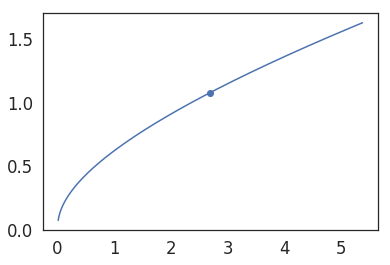

In [9]:
c_grid = cpol(k_grid)

# plot results
fig, ax = plt.subplots()
ax.plot(k_grid, c_grid);
ax.scatter([k_ss], [c_ss]);

In [10]:
def forward_ramsey(k0, cf, dt=0.01, S=S0):
    # initial values
    k, c = k0, cf(k0)
    kpath, cpath = [k], [c]

    for t in range(S):
        gk = k**(alpha-1) - delta - c/k

        k *= 1 + dt*gk
        c = cf(k)

        # store
        kpath.append(k)
        cpath.append(c)

    return np.array(kpath), np.array(cpath)

In [11]:
def solow_policy(s):
    return lambda k: (1-s)*k**alpha

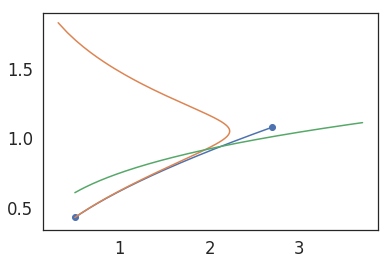

In [12]:
k0 = 0.5
c0 = float(cpol(k0))

csol = solow_policy(0.25)

dt = 0.1
kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
ksol, csol = forward_ramsey(k0, csol, dt=dt, S=S1)
ksim, csim = simulate_ramsey(k0, c0, dt=dt, k_lo=0.4, direc=1)

fig, ax = plt.subplots()
ax.plot(kfwd, cfwd);
ax.plot(ksim, csim);
ax.plot(ksol, csol);
ax.scatter([k0, k_ss], [c0, c_ss]);

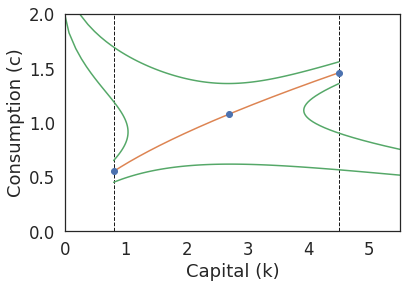

In [17]:
kv0 = [0.8, 4.5]
cv0 = cpol(kv0)
dt = 0.1
err = 0.1

fig, ax = plt.subplots()

for k0, c0 in zip(kv0, cv0):
    kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
    ksim1, csim1 = simulate_ramsey(k0, c0-err, dt=dt, k_hi=6.0, S=S1, direc=1)
    ksim2, csim2 = simulate_ramsey(k0, c0+err, dt=dt, k_hi=6.0, S=S1, direc=1)

    ax.plot(kfwd, cfwd, color=col[1]);
    ax.plot(ksim1, csim1, color=col[2]);
    ax.plot(ksim2, csim2, color=col[2]);
    ax.vlines(k0, 0, 2, color='k', linestyle='--', linewidth=1);
    
ax.scatter(kv0, cv0, color=col[0], zorder=3);
ax.scatter([k_ss], [c_ss], color=col[0], zorder=3);

ax.set_xlim(0, 5.5);
ax.set_ylim(0, 2);

ax.set_xlabel('Capital (k)');
ax.set_ylabel('Consumption (c)');

fig.savefig('')

Now try a policy change?

## Value Functions

In [22]:
from scipy.stats import norm

In [54]:
delt = 0.1
upd = 0.3
sig = norm.cdf
u = np.log
up = lambda x: 1/x

In [69]:
# grid it up
k_lo, k_hi = 0.1, 2.0*k_ss
k_grid = np.linspace(k_lo, k_hi, K)
k_diff = np.diff(k_grid)
y_grid = k_grid**alpha

In [76]:
val = 0.1*np.log(y_grid)
inv = np.zeros_like(k_grid)

for i in range(20000):
    adot = inv - delta*k_grid
    vala_p = np.r_[val[1:]-val[:-1],val[-1]-val[-2]]/np.r_[k_diff,k_diff[-1]]
    vala_n = np.r_[val[1]-val[0],val[1:]-val[:-1]]/np.r_[k_diff[0],k_diff]
    vala = sig(adot)*vala_p + sig(-adot)*vala_n

    inv_new = np.clip(y_grid - 1/vala, -0.3, 0.3)
    val_new = delt*u(y_grid-adot) + (1-delt*rho)*(val + delt*adot*vala)

    if i % 1000 == 0:
        print(i, np.max(np.abs(val_new-val)), np.max(np.abs(inv_new-inv)))
    
    val[:] = upd*val_new + (1-upd)*val
    inv[:] = upd*inv_new + (1-upd)*inv

0 0.0780832033601 0.3
1000 2.27193561162e+45 0.5357742445
2000 5.95303147659e+97 0.403569484812
3000 1.55462112345e+150 1.66533453694e-16
4000 4.04493290893e+202 1.66533453694e-16
5000 1.0483874588e+255 1.66533453694e-16


/home/doug/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in true_divide
  
/home/doug/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in true_divide
  import sys
/home/doug/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  
/home/doug/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/doug/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doug/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doug/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value 

6000 nan nan
7000 nan nan
8000 nan nan
9000 nan nan
10000 nan nan
11000 nan nan
12000 nan nan
13000 nan nan
14000 nan nan
15000 nan nan
16000 nan nan
17000 nan nan
18000 nan nan
19000 nan nan


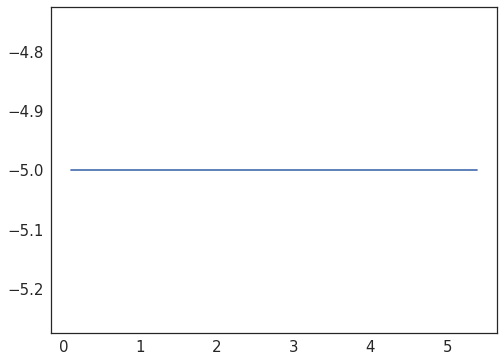

In [66]:
plt.plot(k_grid, inv);